In [ ]:
from typing import TypedDict, Literal, Optional
from langgraph.graph import StateGraph, END
from langchain_core.messages import AIMessage
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
import os
from dotenv import load_dotenv

In [ ]:
# -------------------------
# 0. Setup LLM
# -------------------------
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

groq_llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.1-8b-instant", temperature=0)


In [ ]:
# -------------------------
# 1. Define State Schema
# -------------------------

class UnifiedState(TypedDict, total=False):
    mode: Literal["generate", "improve"]
    task_description: str
    context: Optional[str]
    base_template: Optional[str]
    prompt: Optional[str]
    feedback: Optional[str]
    score: Optional[float]
    issue_found: Optional[bool]
    improved_prompt: Optional[str]

In [ ]:
# -------------------------
# 2. Define Node Functions
# -------------------------

def dispatcher_node(state: UnifiedState) -> dict:
    """Does nothing except pass control to router."""
    return {}

def dispatcher_router(state: UnifiedState) -> str:
    if state.get("mode") == "improve":
        return "PromptImproverDirect"
    else:
        return "ContextBuilder"

def context_builder(state: UnifiedState) -> dict:
    context = f"You are a helpful assistant. Task: {state['task_description']}"
    return {"context": context}

def template_selector(state: UnifiedState) -> dict:
    base_template = "Given the following task, create a useful prompt: {task_description}"
    return {"base_template": base_template}

def prompt_generator(state: UnifiedState) -> dict:
    prompt_input = state["base_template"].format(task_description=state["task_description"])
    prompt = ChatPromptTemplate.from_messages(
        [("system", "You are an expert prompt engineer."), ("human", prompt_input)]
    )
    chain = prompt | groq_llm
    response = chain.invoke({})
    return {"prompt": response.content}

def prompt_evaluator(state: UnifiedState) -> dict:
    prompt_text = state["prompt"]
    eval_input = (f"Evaluate the quality of this prompt: '{prompt_text}'. "
                  f"Your response MUST contain only a single floating-point number from 0.0 to 1.0 and nothing else.")
    prompt = ChatPromptTemplate.from_messages(
        [("system", "You are a strict prompt quality evaluator. Output only a single number score."),
         ("human", eval_input)]
    )
    chain = prompt | groq_llm
    response = chain.invoke({})
    try:
        score_str = ''.join(c for c in response.content if c.isdigit() or c == '.')
        score = float(score_str)
    except (ValueError, IndexError):
        score = 0.5
    issue_found = score < 0.7
    print(f"--- Evaluator: Score = {score}, Issue Found = {issue_found} ---")
    return {"score": score, "issue_found": issue_found}

def critique_node(state: UnifiedState) -> dict:
    critique_prompt = f"Critique the following prompt and suggest specific, actionable improvement areas: {state['prompt']}"
    prompt = ChatPromptTemplate.from_messages(
        [("system", "You are a professional prompt critic."), ("human", critique_prompt)]
    )
    chain = prompt | groq_llm
    response = chain.invoke({})
    print("--- Critique Generated ---")
    return {"feedback": response.content}

def loop_improver(state: UnifiedState) -> dict:
    improve_prompt = (f"Improve the following prompt based on this feedback:\n\n"
                      f"Feedback: {state['feedback']}\n\n"
                      f"Original Prompt: {state['prompt']}")
    prompt = ChatPromptTemplate.from_messages(
        [("system", "You are a senior LLM prompt engineer."), ("human", improve_prompt)]
    )
    chain = prompt | groq_llm
    response = chain.invoke({})
    print("--- Prompt Improved in Loop ---")
    return {"prompt": response.content}

def prompt_improver_direct(state: UnifiedState) -> dict:
    improve_prompt = (f"Improve the following prompt:\n\nPrompt: {state['prompt']}\n\n"
                      f"Improvement Context: {state['context']}")
    prompt = ChatPromptTemplate.from_messages(
        [("system", "You are a senior LLM prompt improver."), ("human", improve_prompt)]
    )
    chain = prompt | groq_llm
    response = chain.invoke({})
    return {"improved_prompt": response.content}

In [ ]:
# -------------------------
# 3. Build the LangGraph
# -------------------------

workflow = StateGraph(UnifiedState)

# Add nodes
workflow.add_node("Dispatcher", dispatcher_node)
workflow.add_node("ContextBuilder", context_builder)
workflow.add_node("PromptTemplateSelector", template_selector)
workflow.add_node("PromptGenerator", prompt_generator)
workflow.add_node("PromptEvaluator", prompt_evaluator)
workflow.add_node("CritiqueNode", critique_node)
workflow.add_node("LoopImproverAgent", loop_improver)
workflow.add_node("PromptImproverDirect", prompt_improver_direct)

# Set entry point
workflow.set_entry_point("Dispatcher")

# Add conditional edge from Dispatcher
workflow.add_conditional_edges(
    "Dispatcher",
    dispatcher_router,
    {
        "PromptImproverDirect": "PromptImproverDirect",
        "ContextBuilder": "ContextBuilder",
    },
)

# Normal edges
workflow.add_edge("ContextBuilder", "PromptTemplateSelector")
workflow.add_edge("PromptTemplateSelector", "PromptGenerator")
workflow.add_edge("PromptGenerator", "PromptEvaluator")

# Conditional logic after evaluation
def evaluator_condition(state: UnifiedState) -> str:
    return "critique_and_improve" if state.get("issue_found") else END

workflow.add_conditional_edges(
    "PromptEvaluator",
    evaluator_condition,
    {
        "critique_and_improve": "CritiqueNode",
        END: END,
    },
)

workflow.add_edge("CritiqueNode", "LoopImproverAgent")
workflow.add_edge("LoopImproverAgent", "PromptEvaluator")
workflow.add_edge("PromptImproverDirect", END)

# Compile app
app = workflow.compile()

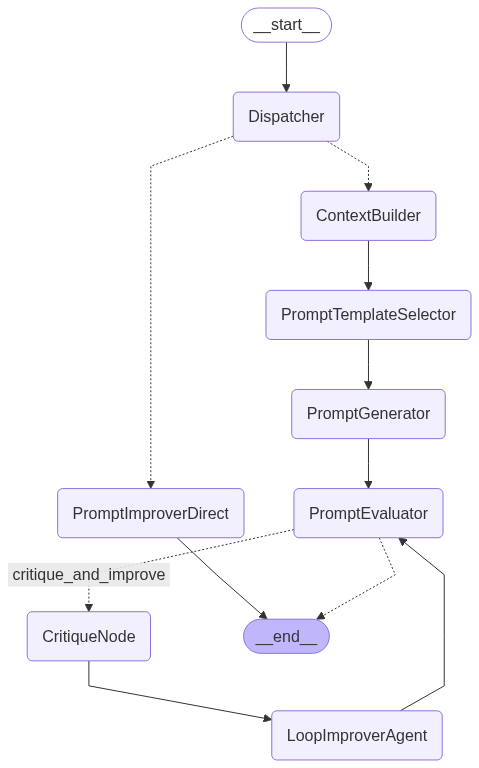

In [7]:
from IPython.display import display, Image, Markdown

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# -------------------------
# 4. Run Examples
# -------------------------

if __name__ == "__main__":
    print("\n=======================================================")
    print("Running: Full Prompt Generation and Iterative Improvement")
    print("=======================================================\n")
    gen_inputs = {
        "mode": "generate",
        "task_description": "Create a prompt to explain the theory of relativity to a 10-year-old.",
    }
    final_result = app.invoke(gen_inputs)
    print("\n--- Final Generated Prompt ---")
    print(final_result.get("prompt"))

    print("\n\n=======================================================")
    print("Running: Direct Prompt Improvement with Context")
    print("=======================================================\n")
    improve_inputs = {
        "mode": "improve",
        "prompt": "Explain relativity.",
        "context": "Make the prompt ask for an explanation using a simple analogy involving a train and a ball.",
    }
    result = app.invoke(improve_inputs)
    print("\n--- Final Improved Prompt ---")
    print(result.get("improved_prompt"))



Running: Full Prompt Generation and Iterative Improvement

--- Evaluator: Score = 0.857, Issue Found = False ---

--- Final Generated Prompt ---
Here's a useful prompt to explain the theory of relativity to a 10-year-old:

"Imagine you're on a train, and you throw a ball straight up in the air. What happens to the ball? Now, imagine your friend is standing outside the train, watching you throw the ball. From their perspective, what happens to the ball? Explain how the theory of relativity says that both you and your friend are right, and that time and space can look different depending on how fast you're moving and where you are."

This prompt uses a relatable scenario to help a 10-year-old understand the core concept of relativity, which is that time and space are relative and can be affected by motion and gravity. By using a simple and concrete example, the prompt makes the theory more accessible and easier to grasp.

Alternatively, you could also use a more visual prompt:

"Imagine